This notebook aims to reproduce the results of the following paper:

[1] Obeid, Dina, Hugo Ramambason, and Cengiz Pehlevan. "Structured and Deep Similarity Matching via Structured and Deep Hebbian Networks." Advances in Neural Information Processing Systems. 2019.

Link to paper: https://openreview.net/pdf?id=Skea6rre8r

In [1]:
using Pkg; for p in ("Knet","IterTools","Plots","LIBSVM"); haskey(Pkg.installed(),p) || Pkg.add(p); end
using Base.Iterators: flatten
using IterTools: ncycle, takenth
using Statistics: mean
using Knet: Knet, conv4, AutoGrad, param, param0,
        pool, mat, KnetArray, nll, zeroone, progress, param, param0, dropout, relu, Data, gpu, accuracy, 
        adagrad, dir, adam, Data, Param, @diff, value, params, grad, progress, progress!, gpu, KnetArray, load, save, sgd
using StatsBase
using LIBSVM

In [2]:
gpu() >= 0

true

In [3]:
#Define one layer of MLP as struct
struct Linear
    w;
    b;
end
    
# Load data
include(Knet.dir("data","mnist.jl"))  # Load data
if gpu() >= 0  # gpu() returns a device id >= 0 if there is a GPU, -1 otherwise
    atype = KnetArray{Float32}  # KnetArrays are stored and operated in the GPU
    dtrn,dtst = mnistdata(batchsize=1;xsize=(784,:),xtype=atype) # The setting is online so batchsize is set to 1.
    
    # Create constructor for Linear layer as Param
    Linear(i::Int,o::Int,scale=0.01) = Linear(Param(atype(scale * randn(o,i))), Param(atype(zeros(o))))
    # initialize MLP 
    model = Linear(784,10)
end

┌ Info: Loading MNIST...
└ @ Main /kuacc/users/merveoral17/.julia/packages/Knet/vxHRi/data/mnist.jl:33


Linear(P(KnetArray{Float32,2}(10,784)), P(KnetArray{Float32,1}(10)))

In [4]:
# Returns output of the MLP
(m::Linear)(x) = m.w * x .+ m.b

In [5]:
# Loss function for MLP
(m::Linear)(x, y) = Knet.nll(m(x), y)

In [6]:
# Returns average loss on a dataset
(m::Linear)(data::Data) = mean(m(x,y) for (x,y) in data)

In [10]:
function trainresults(model)
        # We will train 120 epochs (the following returns an iterator, does not start training)
        training = sgd(model, ncycle(dtrn,10))
        # We will snapshot model and train/test loss and errors
        snapshot() = (deepcopy(model),model(dtrn),model(dtst),zeroone(model,dtrn),zeroone(model,dtst))
        # Snapshot results once every epoch (still an iterator)
        snapshots = (snapshot() for x in takenth(progress(training),length(dtrn)))
        # Run the snapshot/training iterator, reshape and save results as a 5x100 array
        lin = reshape(collect(flatten(snapshots)),(5,:))
    return lin
end

trainresults (generic function with 1 method)

In [11]:
lin=trainresults(Linear(784,10))

┣████████████████████┫ [100.00%, 600000/600000, 05:56/05:56, 1686.43i/s]                 ┫ [1.41%, 8443/600000, 00:06/06:33, 2655.99i/s] ▍                   ┫ [2.09%, 12568/600000, 00:08/06:00, 2187.81i/s] ▌                   ┫ [2.87%, 17192/600000, 00:10/05:33, 2323.43i/s] ▋                   ┫ [3.66%, 21946/600000, 00:12/05:15, 2503.34i/s] ▉                   ┫ [4.47%, 26834/600000, 00:14/05:03, 2636.93i/s] █                   ┫ [5.30%, 31802/600000, 00:16/04:53, 2562.26i/s] █▏                  ┫ [6.15%, 36878/600000, 00:18/04:45, 2670.68i/s] █▍                  ┫ [7.00%, 41973/600000, 00:20/04:39, 2706.80i/s] █▌                  ┫ [7.84%, 47037/600000, 00:22/04:35, 2715.98i/s] █▋                  ┫ [8.69%, 52142/600000, 00:24/04:31, 2713.67i/s] █▉                  ┫ [9.53%, 57193/600000, 00:26/04:28, 2646.11i/s] ██▎                 ┫ [11.71%, 70272/600000, 00:42/05:55, 2684.93i/s] ██▌                 ┫ [12.56%, 75367/600000, 00:44/05:47, 2712.93i/s] ██▋                 ┫ [13.39%, 80

5×10 Array{Any,2}:
  Linear(P(KnetArray{Float32,2}(10,784)), P(KnetArray{Float32,1}(10)))  …   Linear(P(KnetArray{Float32,2}(10,784)), P(KnetArray{Float32,1}(10)))
 0.942077                                                                  0.900426                                                             
 1.01719                                                                   1.08446                                                              
 0.125283                                                                  0.114833                                                             
 0.1307                                                                    0.1238                                                               

# Visualizing learned representations
The paper learns representations in an unsupervised setting. Even though it is supervised MLP updated with SGD in an online setting can be a used as a baseline. Model.w is the representations learned.

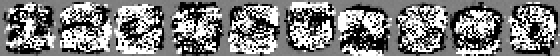

"Epoch 9"

In [12]:
# Let us visualize the evolution of the weight matrix as images below
# Each row is turned into a 28x28 image with positive weights light and negative weights dark gray
using Images, ImageMagick
for t in 10 .^ range(0,stop=log10(size(lin,2)),length=20) #logspace(0,2,20)
    i = ceil(Int,t)
    f = lin[1,i]
    w1 = reshape(Array(value(f.w))', (28,28,1,10))
    w2 = clamp.(w1.+0.5,0,1)
    IJulia.clear_output(true)
    display(hcat([mnistview(w2,i) for i=1:10]...))
    display("Epoch $(i-1)")
    sleep(1) # (0.96^i)
end

# Feed output to a linear SVM to classify
